# Dependence

In [257]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [258]:
steps = 10000
layers = np.array([2,32,64,32,2])
lr = 0.001

# Build mesh

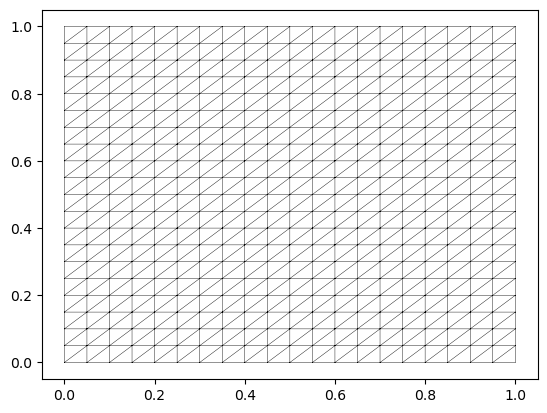

In [259]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
Vc = torch.stack([x,y],dim=1)

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris)

#boundarys = V[(V[:,0]==0.0) | (V[:,1]==0.0) | (V[:,0]==1.0) | (V[:,1]==1.0)]
left_boundarys = Vc[(Vc[:,0]==0.0)]
bottom_boundarys = Vc[(Vc[:,1]==0.0)]
top_boundarys = Vc[(Vc[:,1]==1.0)]
right_boundarys = Vc[(Vc[:,0]==1.0)]

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Moving Mesh Functions

In [260]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def metric(V):
    u_x_y = U_x_y(V)
    uxy_norm = 0.1 * torch.linalg.norm(u_x_y,dim=1)**2 + 1
    return torch.diag_embed(uxy_norm.unsqueeze(-1).expand(-1,2),dim1=-2,dim2=-1)
    
    
# def metric(V):
#     u_x_y = U_x_y(V)
#     col = u_x_y.unsqueeze(2)
#     row = u_x_y.unsqueeze(1)
#     u_x_y_2 = col@row
#     u_x_y_2[:,0,0] += 1
#     u_x_y_2[:,1,1] += 1
#     return u_x_y_2
#     eigenvalues, eigenvectors = torch.linalg.eigh(u_x_y_2)
#     sqrt_eigenvalues = torch.sqrt(eigenvalues)
#     return eigenvectors @ torch.diag_embed(sqrt_eigenvalues) @ eigenvectors.transpose(1,2)

# Auxiliary Functions


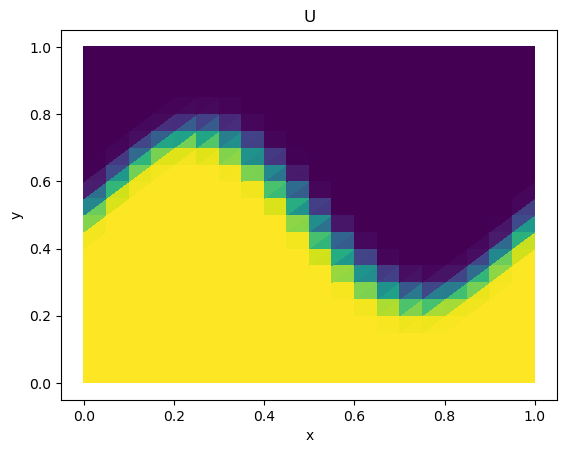

In [261]:
def area(V,tris):
    v1,v2,v3 = V[tris[:,0]],V[tris[:,1]],V[tris[:,2]]
    return 0.5*torch.abs((v2[:,0]-v1[:,0])*(v3[:,1]-v1[:,1])-(v3[:,0]-v1[:,0])*(v2[:,1]-v1[:,1]))
    
def centroid(V,tris):
    return (V[tris[:,0]]+V[tris[:,1]]+V[tris[:,2]])/3.0

def Plot(V, U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()
    
Plot(Vc,U(Vc))

# Neural Network

In [262]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a    
    
    def jacobian(self,V):
        V.requires_grad = True
        xy = self.forward(V)
        x = xy[:,0].unsqueeze(1)
        y = xy[:,1].unsqueeze(1)
        dx = autograd.grad(x,V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        dy = autograd.grad(y,V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        return torch.stack([dx,dy],dim=1)
    
    def loss_BC(self,BC):
        return self.loss_function(self.forward(BC[0,:,:2])[:,0],BC[0,:,2]) + \
               self.loss_function(self.forward(BC[1,:,:2])[:,0],BC[1,:,2]) + \
               self.loss_function(self.forward(BC[2,:,:2])[:,1],BC[2,:,2]) + \
               self.loss_function(self.forward(BC[3,:,:2])[:,1],BC[3,:,2])
    
    def loss_G(self,V_ref,tris):
        areas = area(V_ref,tris)
        centroids = centroid(V_ref,tris)
        #cx = self.forward(centroids)
        Vc = self.forward(V_ref)
        cx = centroid(Vc,tris)
        J = self.jacobian(centroids)
        detJ = torch.linalg.det(J)
        Jinv = torch.linalg.inv(J)
        JinvT = Jinv.transpose(1,2)
        M = metric(cx)
        M_inv = torch.linalg.inv(M)
        JMJ = Jinv@M_inv@JinvT
        traces = JMJ[:,0,0] + JMJ[:,1,1]  
        return self.loss_function(torch.sum(areas*traces*detJ),torch.tensor(0.0).to(device))

    def loss(self,Vc,tris,BC):      
        return self.loss_G(Vc,tris) + self.loss_BC(BC)
        
        # V.requires_grad = True
        # V_ref.requires_grad = True
        # J = self.jacobian(V_ref,V,tris)
        # JT = J.transpose(1,2)
        # vol = self.area(V,tris)
        # JJT = torch.bmm(J,JT)
        # traces = JJT[:,0,0] + JJT[:,1,1]
        # return torch.dot(vol, traces)

# Train Neural Network

C:\Users\13162\AppData\Local\Temp\ipykernel_33448\2455172087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tris = torch.tensor(tris,dtype=torch.long).to(device)


0 8.384353
1 5.19035
2 4.4209948
3 4.278369
4 4.1303606
5 3.677856
6 3.0739408
7 2.8177688
8 2.9058154
9 3.0066736
10 3.1100657
11 3.1792843
12 3.2238917
13 3.2437704
14 3.2502
15 3.2467768
16 3.234098
17 3.214425
18 3.1829622
19 3.1375113
20 3.076345
21 3.021793
22 2.9695554
23 2.9273229
24 2.9016716
25 2.872565
26 2.8492863
27 2.8393066
28 2.827769
29 2.801213
30 2.7775095
31 2.756252
32 2.7520704
33 2.7626588
34 2.7726521
35 2.7786996
36 2.777943
37 2.7728417
38 2.7676651
39 2.7611878
40 2.7488954
41 2.732658
42 2.715314
43 2.7013054
44 2.6921782
45 2.6868322
46 2.6776185
47 2.665533
48 2.6537216
49 2.6434746
50 2.632953
51 2.619653
52 2.6041977
53 2.587613
54 2.575541
55 2.5664117
56 2.5556602
57 2.5413103
58 2.524782
59 2.507741
60 2.4892094
61 2.46964
62 2.4512954
63 2.4358475
64 2.4211614
65 2.4041483
66 2.3835144
67 2.3600464
68 2.3344378
69 2.3095484
70 2.2869468
71 2.2632065
72 2.2351685
73 2.2029927
74 2.171
75 2.1407282
76 2.1068923
77 2.0688727
78 2.0298183
79 1.9901557
80

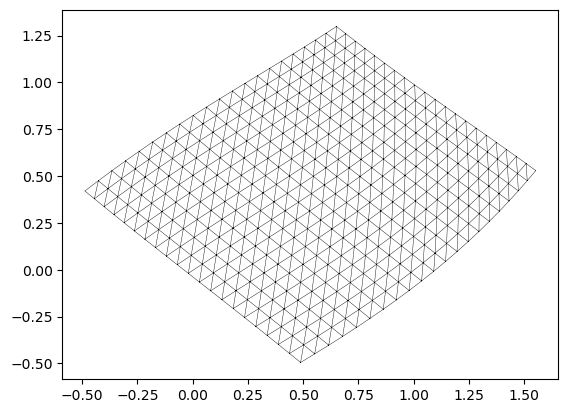

In [263]:
Vc = Vc.float().to(device)
tris = torch.tensor(tris,dtype=torch.long).to(device)

BC1 = torch.cat((left_boundarys,torch.zeros(left_boundarys.shape[0],1)),dim=1)
BC2 = torch.cat((right_boundarys,torch.ones(right_boundarys.shape[0],1)),dim=1)
BC3 = torch.cat((bottom_boundarys,torch.zeros(bottom_boundarys.shape[0],1)),dim=1)
BC4 = torch.cat((top_boundarys,torch.ones(top_boundarys.shape[0],1)),dim=1)
BC = torch.stack((BC1,BC2,BC3,BC4),dim=0).to(device)

MMPDE_Net = FCN(layers)
MMPDE_Net.to(device)
params = list(MMPDE_Net.parameters())
optimizer = torch.optim.Adam(MMPDE_Net.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = MMPDE_Net.loss(Vc,tris,BC)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(i,loss.detach().cpu().numpy())
    
new_V = MMPDE_Net(Vc).detach().cpu()
plt.triplot(new_V[:,0],new_V[:,1],tris.detach().cpu(),'k-',linewidth=0.3)